# Time and cohort analysis of publication patterns in social sciences and humanities, 2000-2014

This notebook accompanies an article in preparation, in which we carry out a cohort analysis of publication patterns, based on the [Flemish VABB-SHW database](https://www.ecoom.be/en/vabb).

## Table of contents

* [Setup](#Setup)
* [Descriptive statistics](#Descriptive-statistics)
* [Results](#Results)
    * [Peer review](#Peer-review)
    * [Language](#Language)
    * [Publication types](#Publication-types)
    * [WoS indexation](#WoS-indexation)

## Setup

First, we load some required packages and set a few options for the display of figures.

In [1]:
import os
import pandas as pd
import seaborn as sns
import warnings
from collections import Counter

import cohort

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.3)

# Ignore warning that seems to originate in this particular seaborn version
warnings.filterwarnings('ignore', category=FutureWarning)

Load data.

In [2]:
mt = cohort.load_data()

Make a small helper function to translate columns to simplified version. This is useful to, e.g., have just English, Dutch, and Other for language, instead of 30 or so different languages.

In [3]:
def translate_column(mt, col, translation, other='Other'):
    return mt.loc[mt[col].notna(), col].apply(lambda x: translation.get(x, other))

Make sure we have an `output` folder to put stuff into.

In [4]:
if not os.path.exists('output/'):
    os.mkdir('output')

## Descriptive statistics

Table 1, absolute numbers:

In [5]:
tmp = mt.groupby(['infogpstd', 'pubyear']).size().unstack().fillna(0).astype(int).T
tmp['Peer-reviewed'] = tmp['gp'] + tmp['wos']
tmp = tmp.rename(columns={'pubchannel': 'Not peer-reviewed', 'rest': 'Not counted for other reasons'}).drop(columns=['gp', 'wos'])
tmp

infogpstd,Not peer-reviewed,Not counted for other reasons,Peer-reviewed
pubyear,,,
2000,2486,2459,2009
2001,2639,2552,2382
2002,3266,2579,2612
2003,3112,2726,2844
2004,3685,2969,3266
2005,3790,3031,3423
2006,3935,3138,3754
2007,4347,3051,4202
2008,4451,3223,4605


Table 1, percentages:

In [6]:
(tmp.T / tmp.T.sum()).T

infogpstd,Not peer-reviewed,Not counted for other reasons,Peer-reviewed
pubyear,,,
2000,0.357492,0.353609,0.288898
2001,0.348475,0.336987,0.314538
2002,0.386189,0.304954,0.308857
2003,0.358443,0.313983,0.327574
2004,0.371472,0.299294,0.329234
2005,0.369973,0.295881,0.334147
2006,0.363443,0.289831,0.346726
2007,0.374741,0.263017,0.362241
2008,0.362489,0.262481,0.375031


From now on, we leave out the publications that are not counted for other reasons.

In [7]:
mt = mt.query('infogpstd != "rest"')

In [8]:
len(mt)

122647

Henceforth we use 3-year time periods and 3-year cohorts.

In [9]:
c = cohort.make_cohorts(2000, 2014, 3)
mt['Year'] = mt.pubyear.map(c)

Now we count the authors and publications in each cohort. This requires some trickery:

In [10]:
# Add dummy column, only used for temporary purposes
mt['dummy'] = 1
df = cohort.author_yearly_feature_counts(mt, 'dummy', 'Year', kind='abs')

# Make df with separate col per author
cohort_per_author = df.set_index('aloi')['cohort'].to_dict()
tmp = mt[['pubyear', 'infogpstd']].merge(
        pd.DataFrame((item for item in mt.allauthorids), index=mt.index),
        left_index=True, right_index=True, how='left')
pubs_with_cohorts = tmp.applymap(lambda x: cohort_per_author.get(x, x))

# Count publications
cohort_pub_counts = Counter()
for yr in pubs_with_cohorts.pubyear.unique():
    pubs_with_cohorts2 = (pubs_with_cohorts[pubs_with_cohorts.pubyear == yr]
                          .iloc[:, 2:].apply(lambda x: set(x) - {None}, axis=1))

    for s in pubs_with_cohorts2:
        for item in s:
            cohort_pub_counts[(yr, item)] += 1

Table 2, publication counts:

In [11]:
pd.Series(cohort_pub_counts).unstack().fillna(0).astype(int)

,2000-02,2003-05,2006-08,2009-11,2012-14
2000,4482,0,0,0,0
2001,5015,0,0,0,0
2002,5865,0,0,0,0
2003,5569,931,0,0,0
2004,6175,1558,0,0,0
2005,6203,2150,0,0,0
2006,6440,1736,1063,0,0
2007,6869,2035,1724,0,0
2008,6866,2068,2504,0,0
2009,6947,2157,2281,1331,0


Table 2, author counts:

In [12]:
for label, tmp_mt in [
    ('SSH', mt),
    ('Humanities', cohort.only_pubs_from(mt, cohort.hum)),
    ('Social sciences', cohort.only_pubs_from(mt, cohort.socsci)),
]:
    print(label)
    df = cohort.author_yearly_feature_counts(tmp_mt, 'dummy', 'Year', kind='abs')
    for c in df.cohort.unique():
        df_c = df[df.cohort == c]
        au_c = set(df_c.aloi)
        print(f'Cohort {c}: {len(au_c)} authors')
    print()

SSH
Cohort 2000-02: 4706 authors
Cohort 2003-05: 2775 authors
Cohort 2006-08: 3092 authors
Cohort 2009-11: 3166 authors
Cohort 2012-14: 4459 authors

Humanities
Cohort 2000-02: 2347 authors
Cohort 2003-05: 1205 authors
Cohort 2006-08: 1333 authors
Cohort 2009-11: 1566 authors
Cohort 2012-14: 2124 authors

Social sciences
Cohort 2000-02: 2719 authors
Cohort 2003-05: 2001 authors
Cohort 2006-08: 2400 authors
Cohort 2009-11: 2471 authors
Cohort 2012-14: 3513 authors



Table 3 data:

In [13]:
# Number of authors per cohort and per time unit
for c in df.cohort.unique():
    df_c = df[df.cohort == c]
    au_c = set(df_c.aloi)
    cohort_count = len(au_c)
    print(f'Authors in cohort {c}:')
    for y in df_c.Year.sort_values().unique():
        df_cy = df_c[df_c.Year == y]
        au_cy = set(df_cy.aloi)
        cohort_year_count = len(au_cy)
        print(f'- in {y}: {cohort_year_count} '
              f'({100 * cohort_year_count / cohort_count:.1f}%)')
        au_c &= au_cy
    print(f'- in each time unit: {len(au_c)} '
          f'({100 * len(au_c) / cohort_count:.1f}%)')

Authors in cohort 2000-02:
- in 2000-02: 2719 (100.0%)
- in 2003-05: 1880 (69.1%)
- in 2006-08: 1643 (60.4%)
- in 2009-11: 1422 (52.3%)
- in 2012-14: 1256 (46.2%)
- in each time unit: 1037 (38.1%)
Authors in cohort 2003-05:
- in 2003-05: 2001 (100.0%)
- in 2006-08: 1111 (55.5%)
- in 2009-11: 876 (43.8%)
- in 2012-14: 714 (35.7%)
- in each time unit: 531 (26.5%)
Authors in cohort 2006-08:
- in 2006-08: 2400 (100.0%)
- in 2009-11: 1263 (52.6%)
- in 2012-14: 961 (40.0%)
- in each time unit: 816 (34.0%)
Authors in cohort 2009-11:
- in 2009-11: 2471 (100.0%)
- in 2012-14: 1341 (54.3%)
- in each time unit: 1341 (54.3%)
Authors in cohort 2012-14:
- in 2012-14: 3513 (100.0%)
- in each time unit: 3513 (100.0%)


## Results

### Peer review

In [14]:
infogp_trans = {
    'gp': 'yes',
    'wos': 'yes',
    'pubchannel': 'no',
}
mt['Peer-reviewed'] = translate_column(mt, 'infogpstd', infogp_trans)

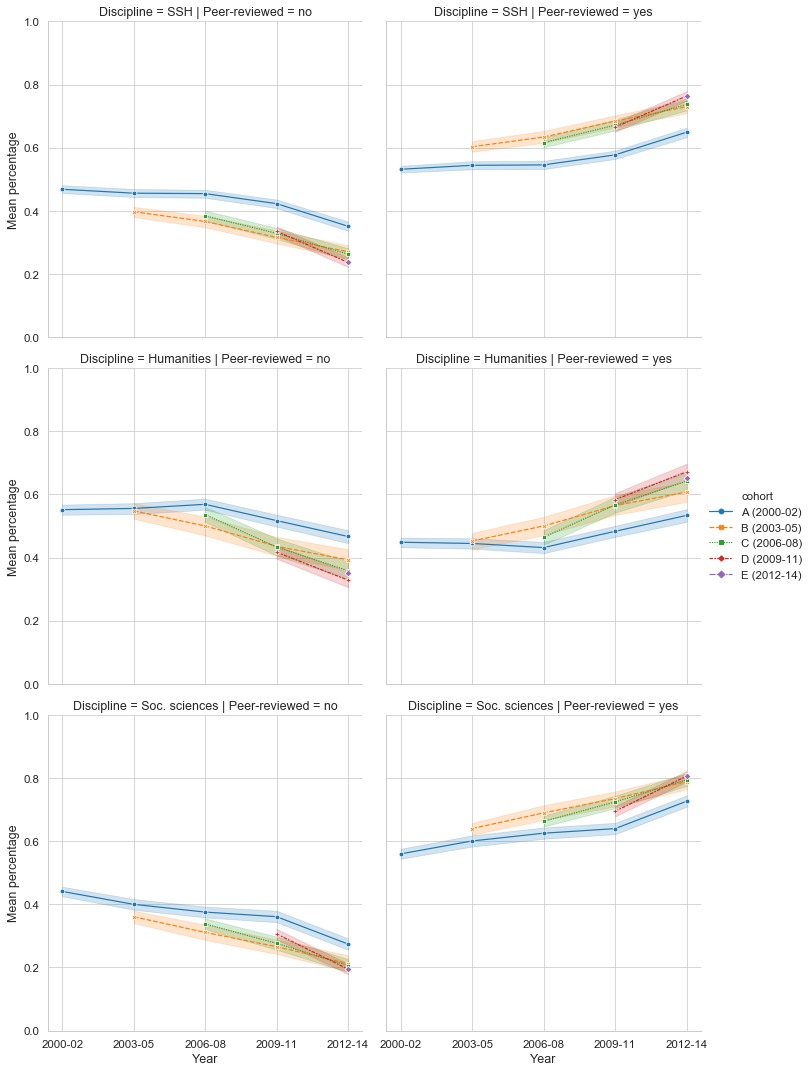

In [15]:
g = cohort.overview_chart_full(mt, 'Peer-reviewed')
g.savefig('output/peer-review.png', dpi=300)

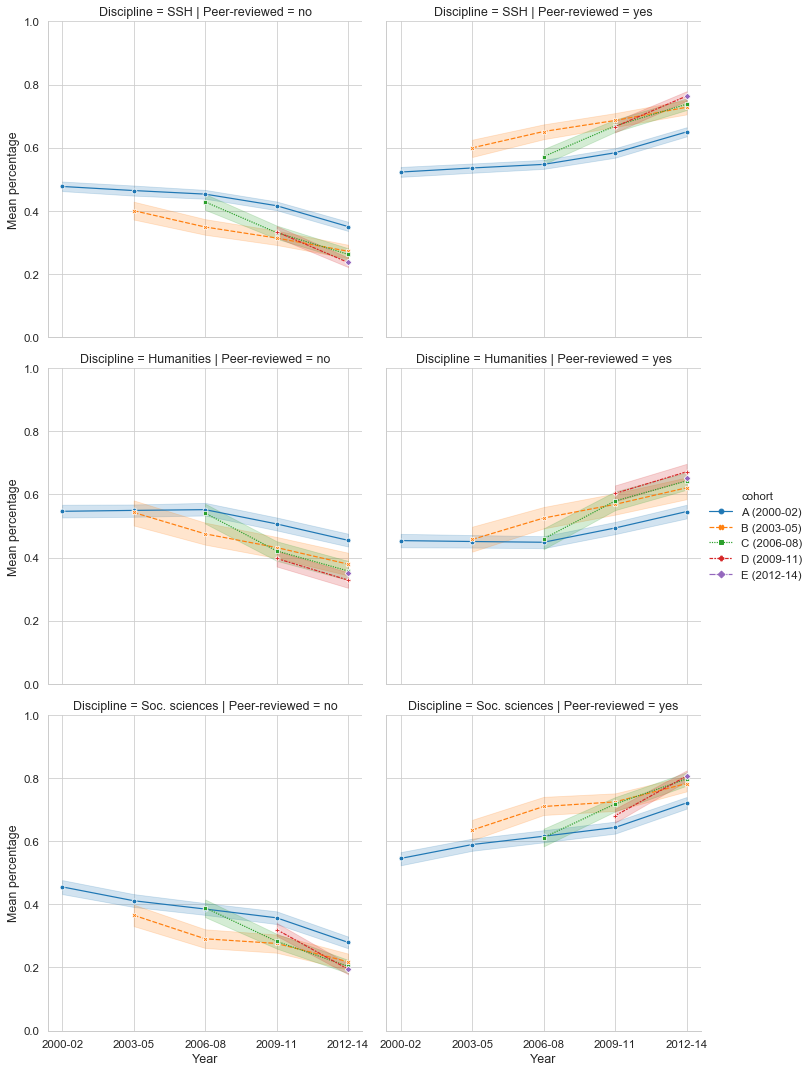

In [16]:
g = cohort.overview_chart_full(mt, 'Peer-reviewed', only_survivors=True)
g.savefig('output/peer-review-survivors.png', dpi=300)

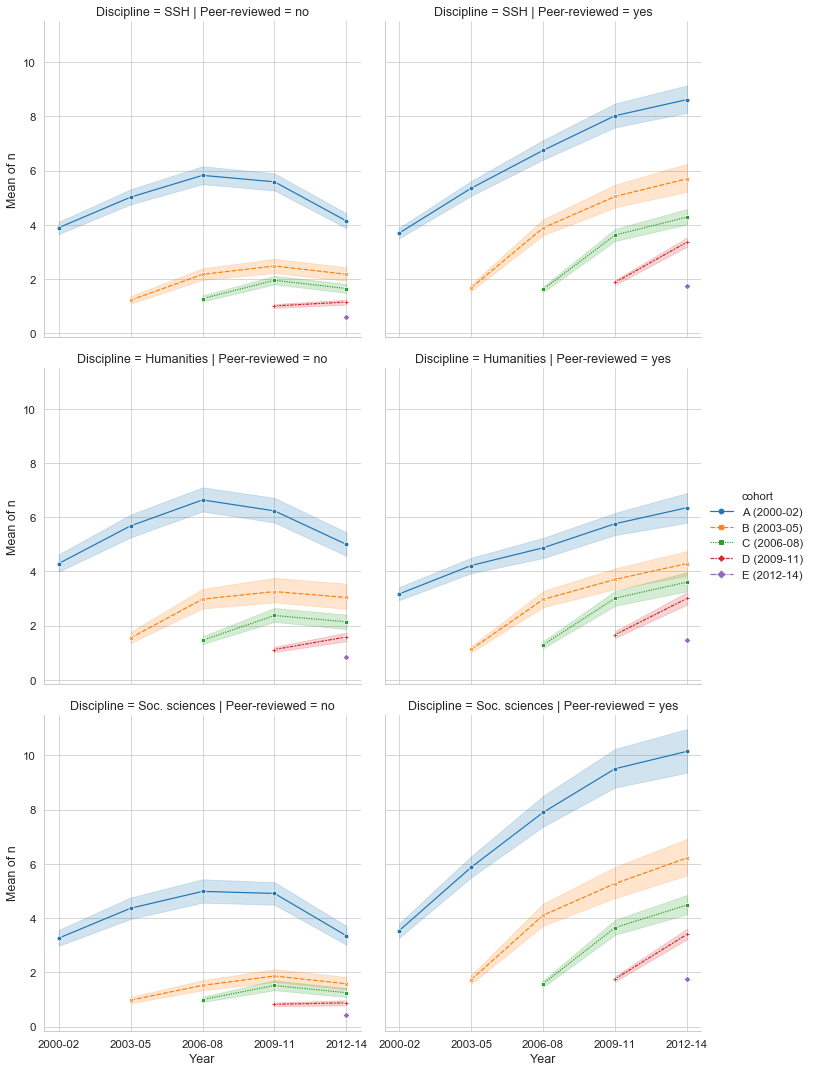

In [17]:
g = cohort.overview_chart_full(mt, 'Peer-reviewed', kind='abs', only_survivors=True)
g.savefig('output/peer-review-survivors-abs.png', dpi=300)

From now on, we only work with the peer-reviewed publications:

In [18]:
mt = mt[mt['Peer-reviewed'] == 'yes']

In [19]:
len(mt) 

66591

### Language

In [20]:
lg_trans = {'dut': 'Dutch', 'eng': 'English'}
mt['Language'] = translate_column(mt, 'lg', lg_trans)

In [21]:
lg_counts = mt.groupby(['Language', 'infogpstd']).size().unstack()
(lg_counts / lg_counts.sum()).T

Language,Dutch,English,Other
infogpstd,,,
gp,0.344651,0.556466,0.098883
wos,0.030254,0.951054,0.018692


In [22]:
lg_counts = mt.groupby('Language').size()
lg_counts / lg_counts.sum()

Language
Dutch      0.222147
English    0.710216
Other      0.067637
dtype: float64

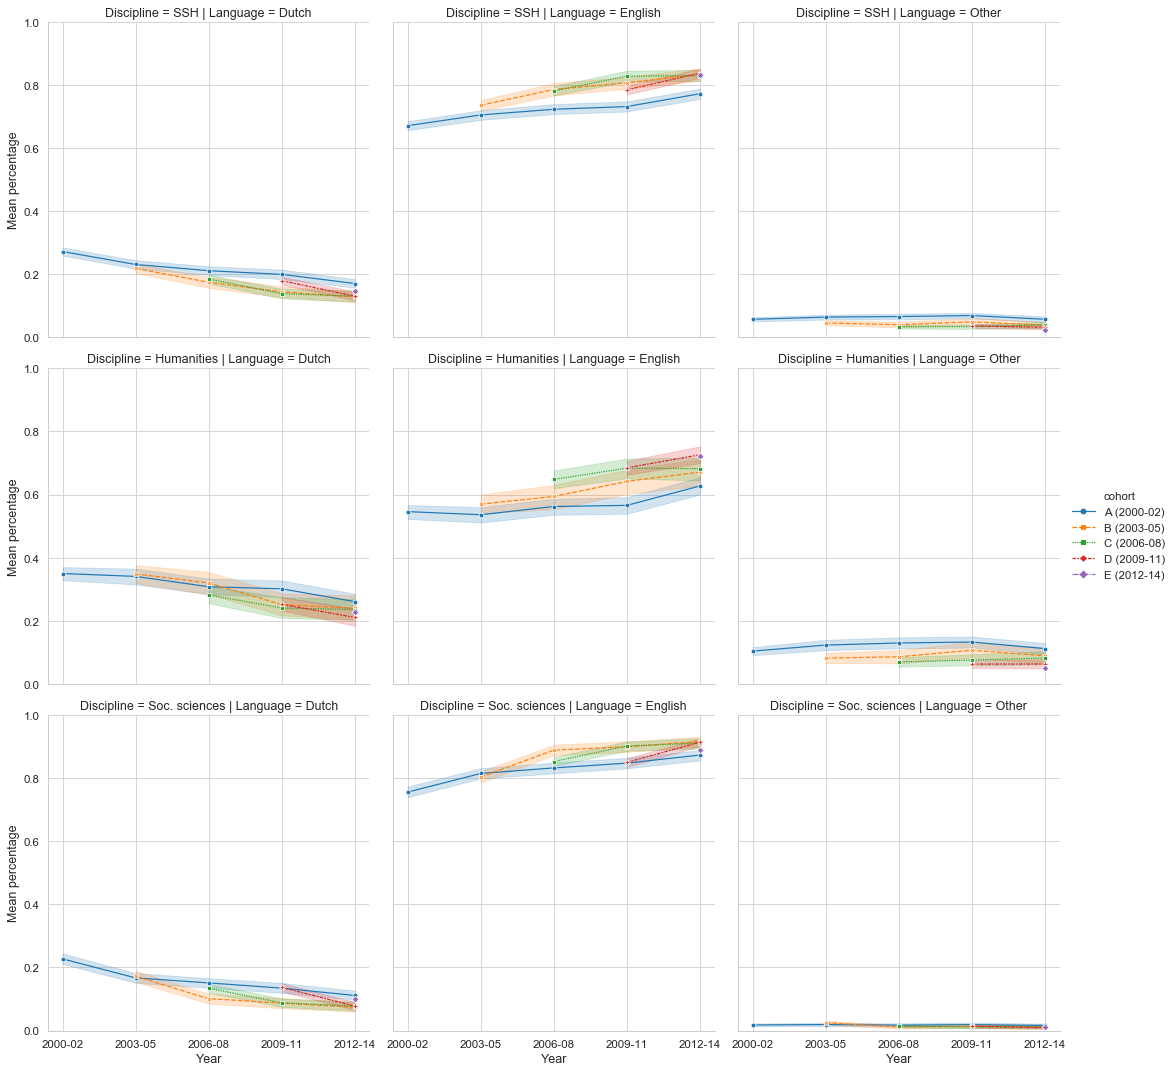

In [23]:
g = cohort.overview_chart_full(mt, 'Language')
g.savefig('output/language.png', dpi=300)

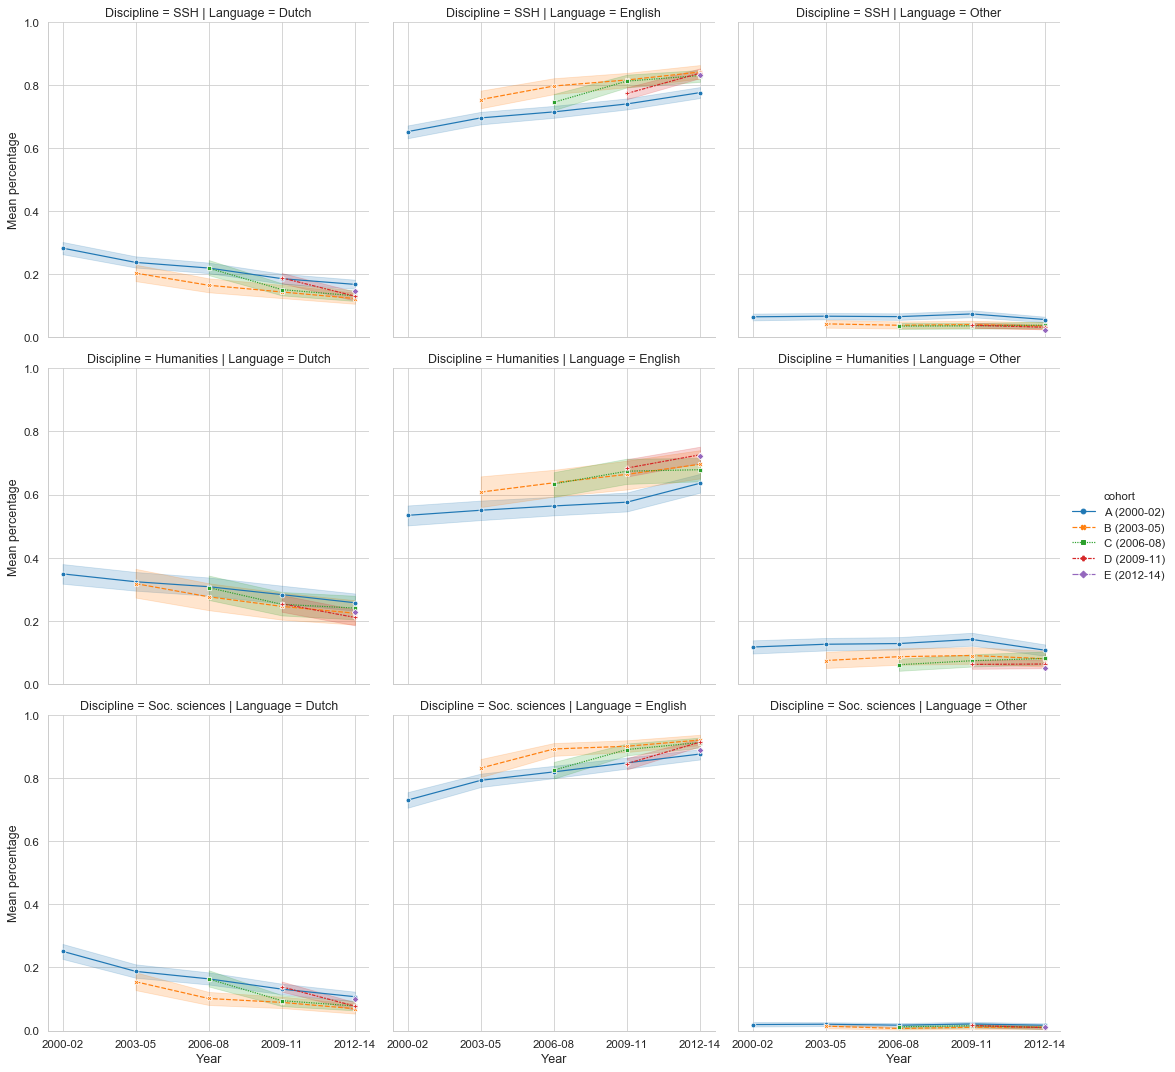

In [24]:
g = cohort.overview_chart_full(mt, 'Language', only_survivors=True)
g.savefig('output/language-survivors.png', dpi=300)

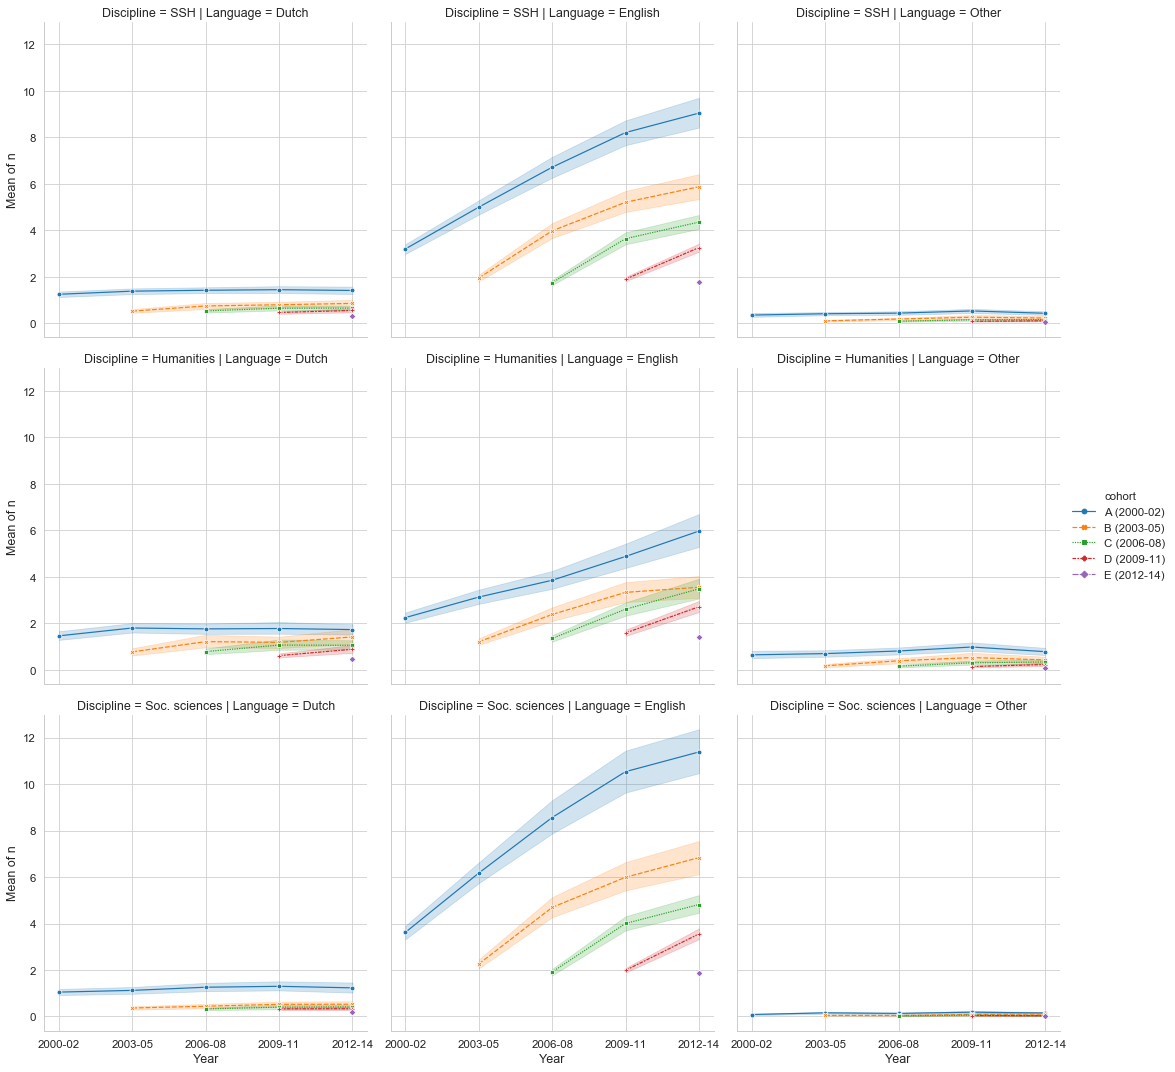

In [25]:
g = cohort.overview_chart_full(mt, 'Language', kind='abs', only_survivors=True)
g.savefig('output/language-survivors-abs.png', dpi=300)

### Publication types

In [26]:
pubtype_trans = {
    'VABB-1': 'Journal article',
    'VABB-2': 'Book publication',
    'VABB-3': 'Book publication',
    'VABB-4': 'Book publication',
    'VABB-5': 'Proceedings',
}
mt['Publication type'] = translate_column(mt, 'VABB-publicatietype', pubtype_trans)

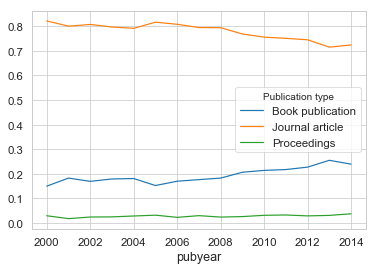

In [27]:
s = mt.groupby(['pubyear', 'Publication type']).size().unstack()
s = (s.div(s.sum(axis=1), axis=0))
s.plot()

In [28]:
s.div(s.sum(axis=1), axis=0)

Publication type,Book publication,Journal article,Proceedings
pubyear,,,
2000,0.149328,0.821802,0.028870
2001,0.182200,0.800588,0.017212
2002,0.168836,0.807427,0.023737
2003,0.178622,0.797117,0.024262
2004,0.180343,0.791794,0.027863
2005,0.151914,0.816827,0.031259
2006,0.169419,0.808205,0.022376
2007,0.175869,0.794860,0.029272
2008,0.182193,0.794354,0.023453


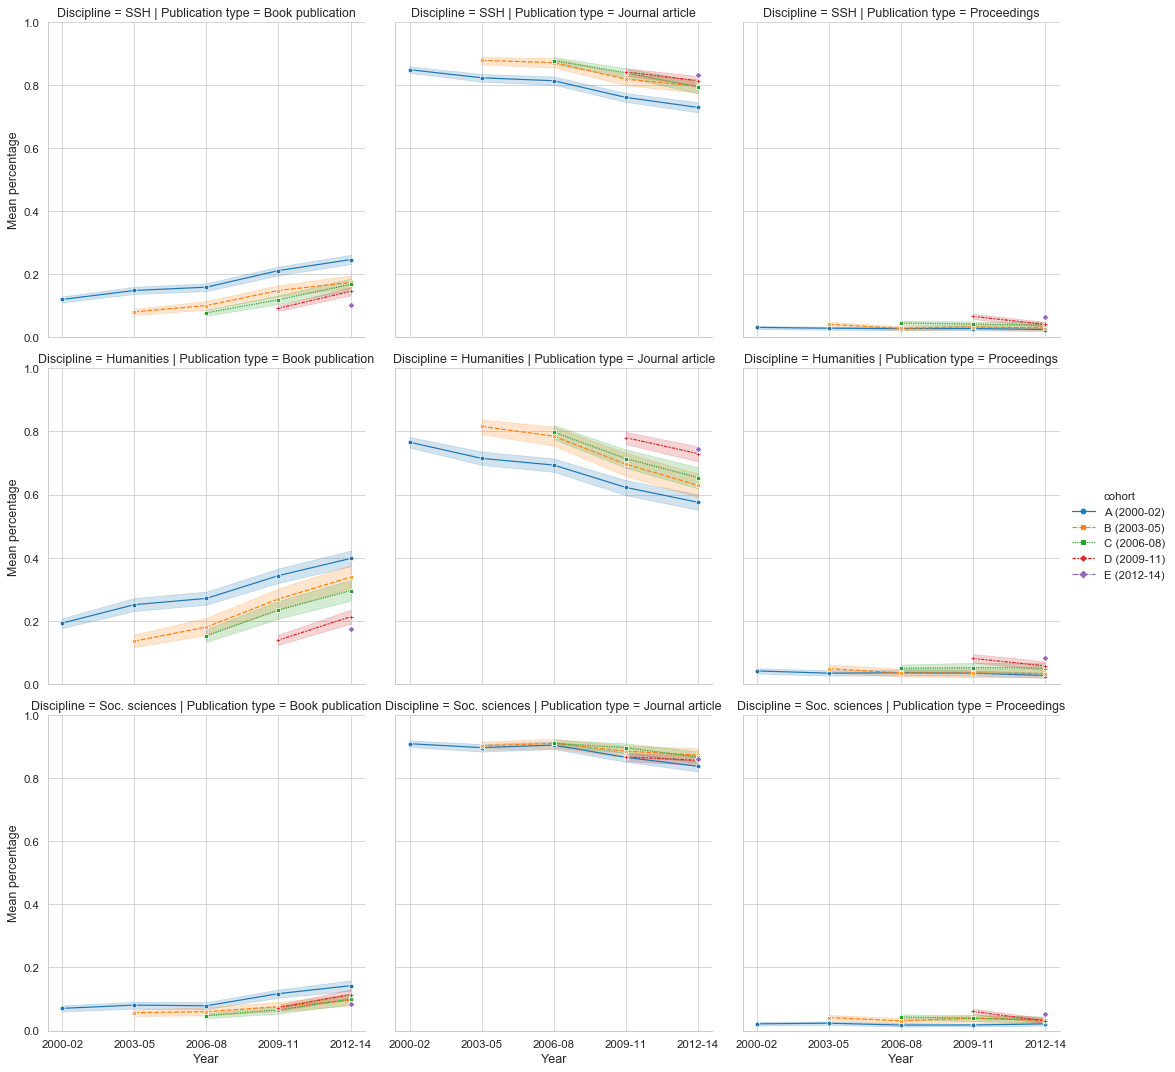

In [29]:
g = cohort.overview_chart_full(mt, 'Publication type')
g.savefig('output/pubtype.png', dpi=300)

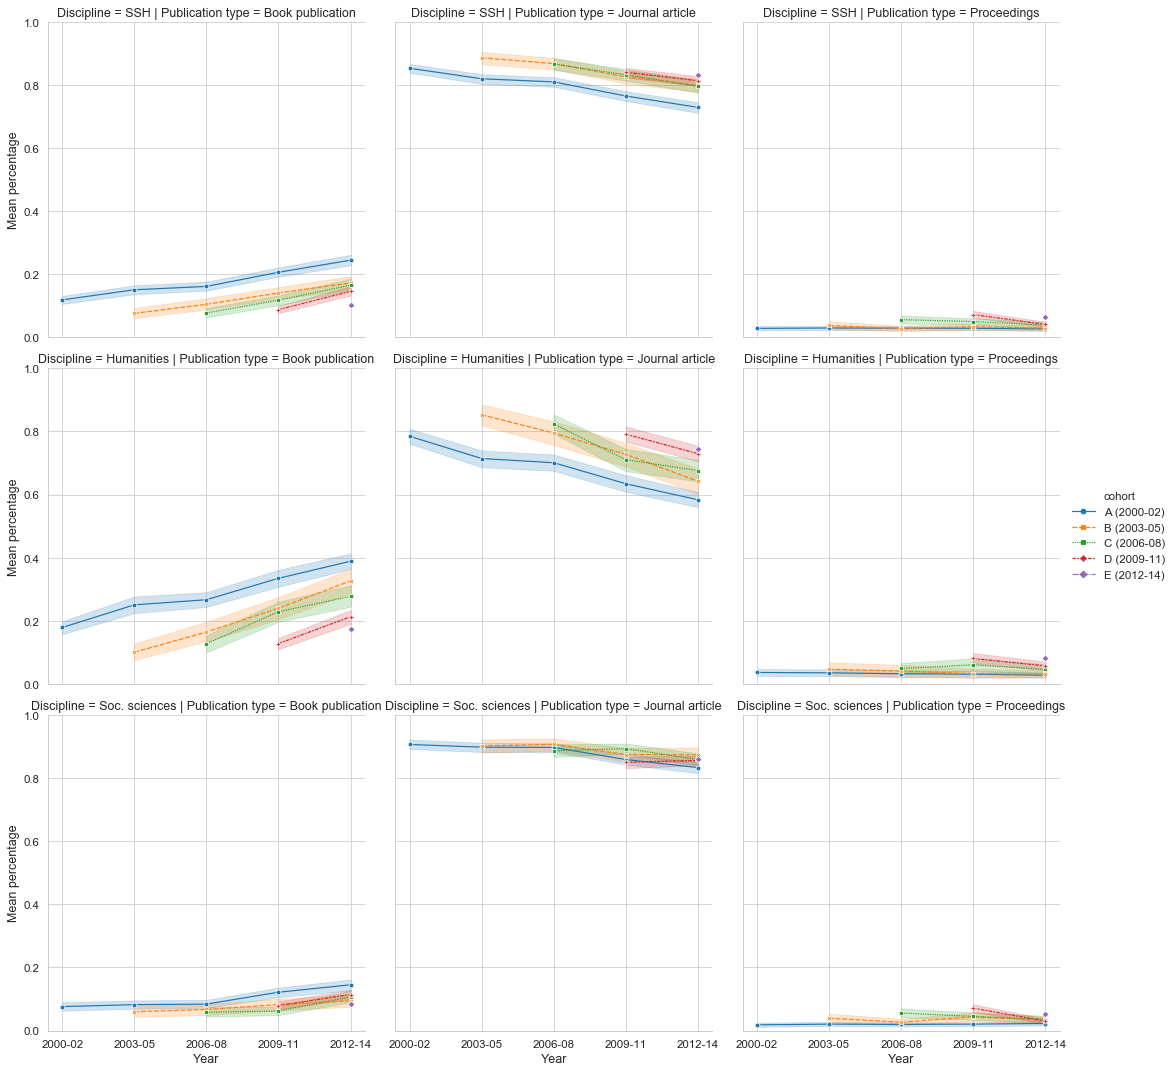

In [30]:
g = cohort.overview_chart_full(mt, 'Publication type', only_survivors=True)
g.savefig('output/pubtype-survivors.png', dpi=300)

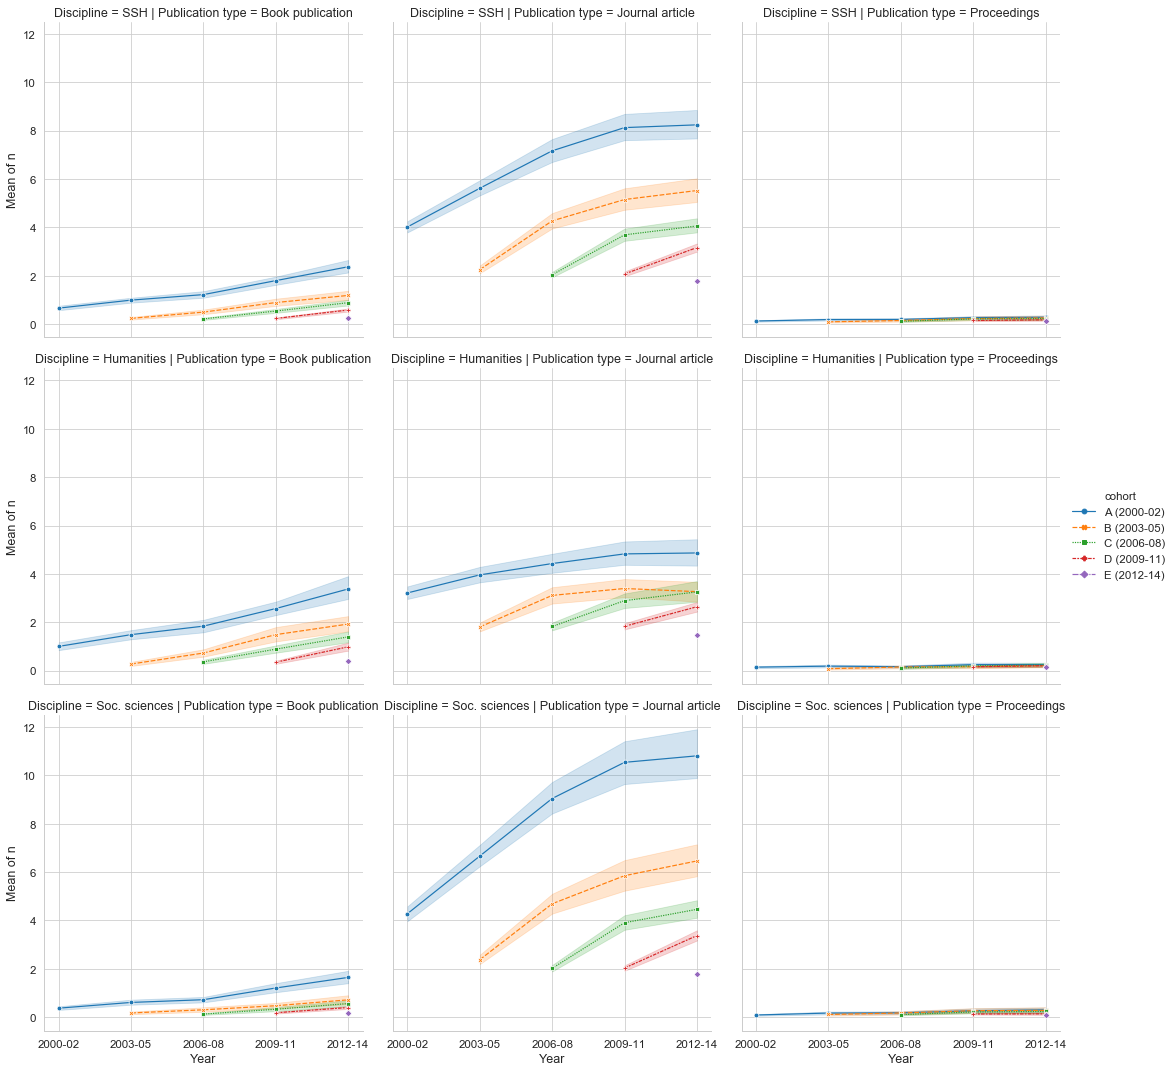

In [31]:
g = cohort.overview_chart_full(mt, 'Publication type', kind='abs', only_survivors=True)
g.savefig('output/pubtype-survivors-abs.png', dpi=300)

In [32]:
for field in [cohort.socsci, cohort.hum]:
    df = cohort.only_pubs_from(mt, field)
    counts = df.groupby('Publication type').size()
    print(counts / counts.sum())

Publication type
Book publication    0.124266
Journal article     0.848959
Proceedings         0.026775
dtype: float64
Publication type
Book publication    0.293970
Journal article     0.675094
Proceedings         0.030936
dtype: float64


### WoS indexation

We only do the analysis for journal articles and proceedings, since book publications cannot be included in WoS (Book Citation Index is not used in the funding system).

In [33]:
mt2 = mt[mt['VABB-publicatietype'].isin(['VABB-1', 'VABB-5'])].copy()
mt2['Indexed in WoS'] = translate_column(mt, 'infogpstd', {'wos': 'yes', 'gp': 'no'})

In [34]:
len(mt2)

53040

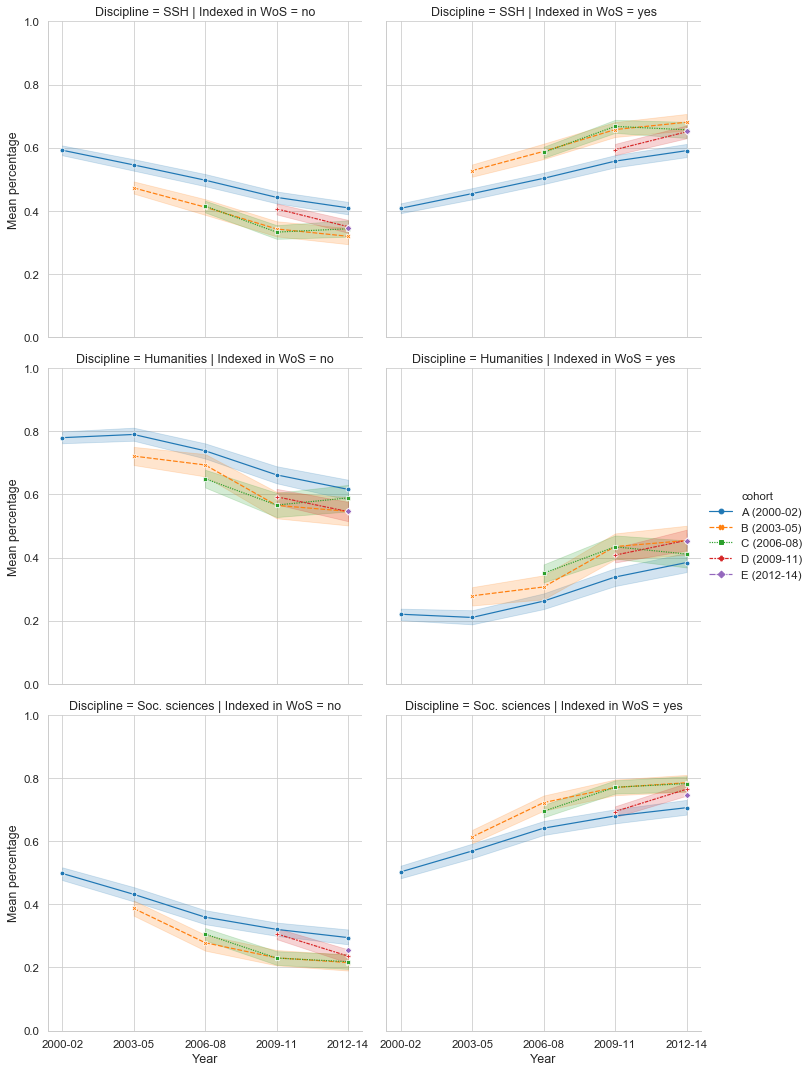

In [35]:
g = cohort.overview_chart_full(mt2, 'Indexed in WoS')
g.savefig('output/wos.png', dpi=300)

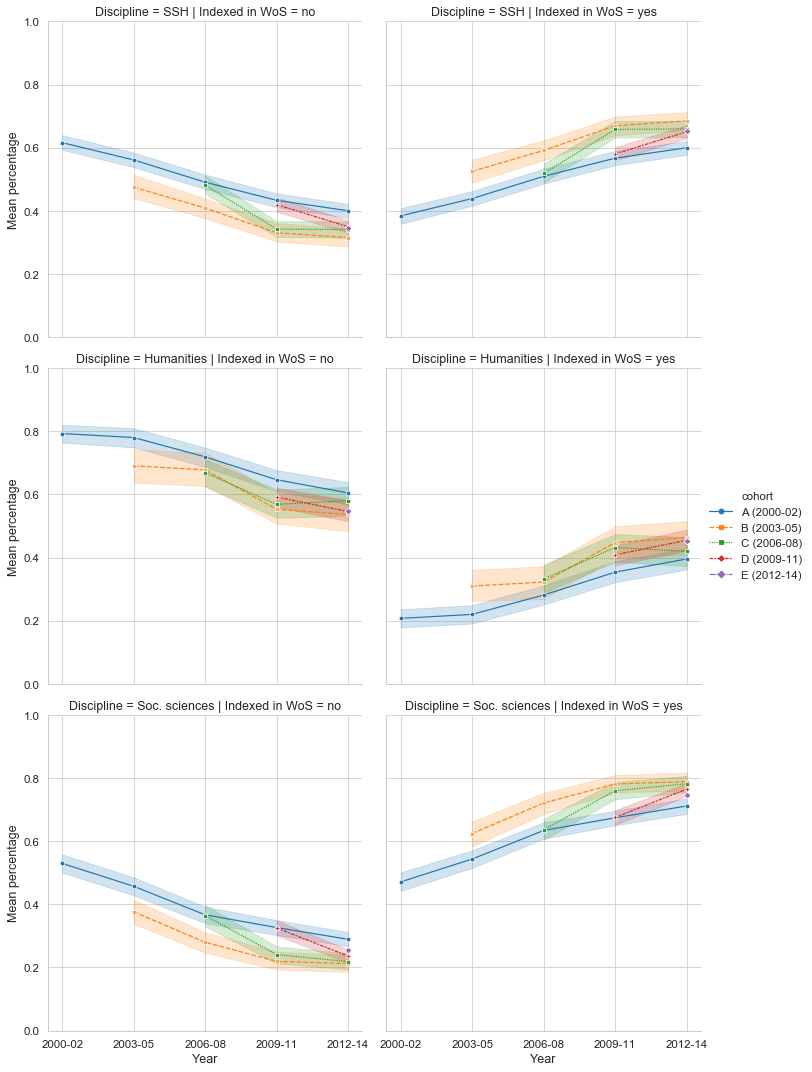

In [36]:
g = cohort.overview_chart_full(mt2, 'Indexed in WoS', only_survivors=True)
g.savefig('output/wos-survivors.png', dpi=300)

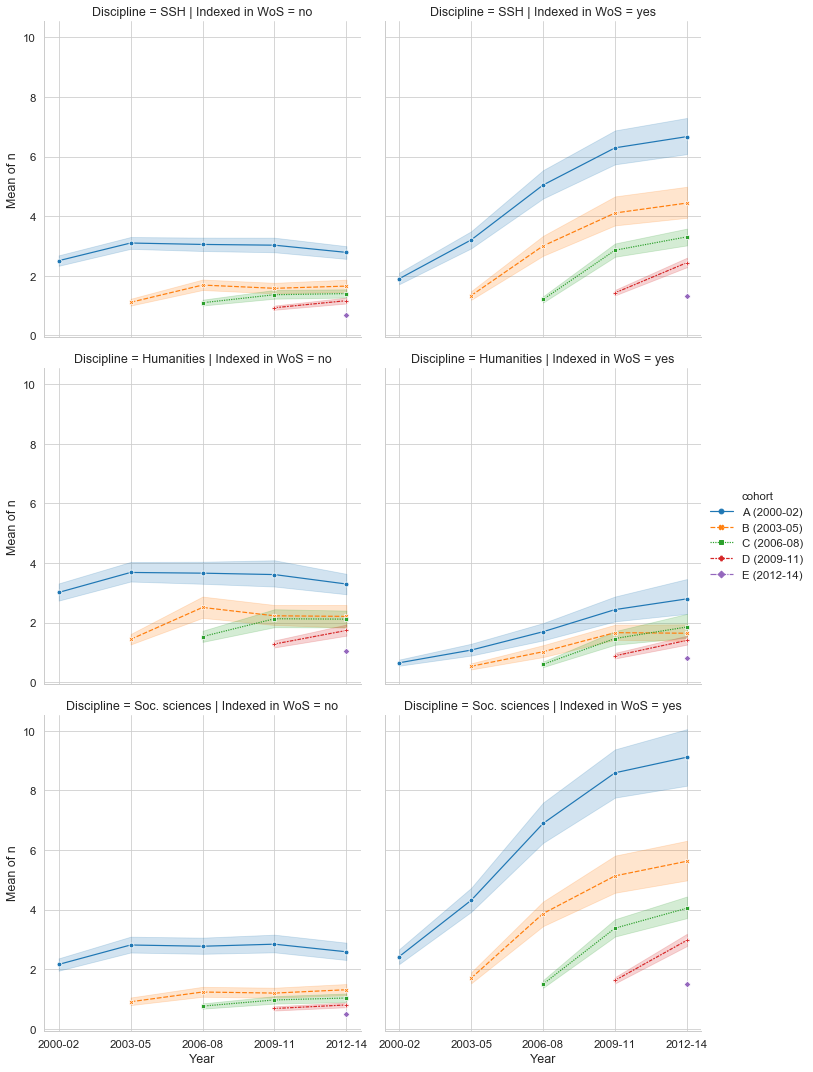

In [37]:
g = cohort.overview_chart_full(mt2, 'Indexed in WoS', kind='abs', only_survivors=True)
g.savefig('output/wos-survivors-abs.png', dpi=300)